In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.metrics import root_mean_squared_error
from reservoirpy.datasets import mackey_glass
import pandas as pd
import pickle
from datetime import datetime
import seaborn as sns

In [2]:
import wfdb
from wfdb import processing

# Download a sample record from the MIT-BIH Arrhythmia Database
record_name = '100'
#wfdb.dl_database('mitdb', './mitdb')

# Read the ECG signal and annotation from the dataset
record = wfdb.rdrecord(f'./mitdb/{record_name}')
annotation = wfdb.rdann(f'./mitdb/{record_name}', 'atr')

# Extracting the signal (ECG data)
ecg_signal = record.p_signal

# Display some information
print(f"Signal shape: {ecg_signal.shape}")
print(f"Signal sampling rate: {record.fs} Hz")

Signal shape: (650000, 2)
Signal sampling rate: 360 Hz


In [3]:
ecg_dataset=[]
for i in range(100,235):
    record_name = str(i)
    #wfdb.dl_database('mitdb', './mitdb')

    try:
        # Read the ECG signal and annotation from the dataset
        record = wfdb.rdrecord(f'./mitdb/{record_name}')
        annotation = wfdb.rdann(f'./mitdb/{record_name}', 'atr')

        # Extracting the signal (ECG data)
        ecg_signal = record.p_signal

        ecg_dataset.append(ecg_signal[:, 0])
        ecg_dataset.append(ecg_signal[:, 1])
    except:
        ...

In [4]:
class EchoStateNetwork:
    def __init__(self, n_input, n_reservoir, n_output, spectral_radius=1.25, sparsity=0.1, alpha = 1, noise=0.001, random_state=None):
        """
        Initialize the Echo State Network.
        
        Parameters:
        - n_input: Number of input units.
        - n_reservoir: Number of reservoir neurons.
        - n_output: Number of output units.
        - spectral_radius: Scaling factor for the reservoir weights.
        - sparsity: Fraction of weights set to zero in the reservoir.
        - noise: Amount of noise to add to the reservoir dynamics.
        - random_state: Random seed for reproducibility.
        """
        # just for the random seed for replicability, can be 0
        if random_state is not None:
            np.random.seed(random_state)
        
        self.n_input = n_input
        self.n_reservoir = n_reservoir
        self.n_output = n_output
        self.spectral_radius = spectral_radius
        # this number is used for making the sparsity
        self.sparsity = sparsity
        self.alpha = alpha
        
        # pbbly for the noise ammount
        self.noise = noise

        # Input weight matrix
        self.W_in = np.random.uniform(-1, 1, (n_reservoir, n_input + 1))  # +1 for bias term

        # Reservoir weight matrix (random sparse matrix)
        W_res = np.random.rand(n_reservoir, n_reservoir) - 0.5
        # 0 out every place that has more thant sparsity based on a normaly distributed matrix
        W_res[np.random.rand(*W_res.shape) > sparsity] = 0
        # Rescale to ensure the spectral radius
        rho_W = np.max(np.abs(np.linalg.eigvals(W_res)))
        self.W_res = W_res * (spectral_radius / rho_W)
        
        

        # Output weight matrix (initialized later)
        self.W_out = None
        
    def get_reservoir(self):
        return self.W_res
    
    def get_w_in(self):
        return self.W_in
    
    def set_reservoir(self, res):
        self.W_res = res
    
    def set_w_in(self,w_in):
        self.W_in = w_in

    def _update_reservoir(self, x, r):
        """
        Update the reservoir state.
        
        Parameters:
        - x: Current input.
        - r: Previous reservoir state.
        
        Returns:
        - Updated reservoir state.
        """
        input_with_bias = np.hstack([1.0, x])  # Add bias term to input
        # input_wiht_bias.shape == 1,self.n_input+1 
        # W_in.shape == self.n_reservoir, self.n_input+1
        # np.dot(self.W_in, input_with_bias).shape == self.n_reservoir
        # r_new.shape == self.n_reservoir
        r_new = np.tanh(np.dot(self.W_in, input_with_bias) + np.dot(self.W_res, r))# + self.noise * np.random.randn(self.n_reservoir))

        r_new = ( 1 - self.alpha ) * r + self.alpha * r_new
        return r_new

    def fit(self, X, y, beta=1e-6):
        """
        Train the output weights using ridge regression.
        
        Parameters:
        - X: Input data (n_samples, n_timesteps, n_features).
        - y: Target data (n_samples, n_timesteps, n_output).
        - ridge_reg: Regularization strength for ridge regression.
        """
        n_samples, n_timesteps, _ = X.shape
        
        # Initialize reservoir states
        reservoir_states = np.zeros((n_samples * n_timesteps, self.n_reservoir))

        # Collect reservoir states
        for i in range(n_samples):
            r = np.zeros(self.n_reservoir)  # Initial reservoir state
            for t in range(n_timesteps):
                r = self._update_reservoir(X[i, t], r)
                reservoir_states[i * n_timesteps + t] = r

        # Add bias term to reservoir states
        reservoir_states_with_bias = np.hstack([np.ones((reservoir_states.shape[0], 1)), reservoir_states])

        # Flatten target data
        target = y.reshape(-1, self.n_output)

        # Ridge regression to compute output weights
        self.W_out = np.dot(
            np.linalg.pinv(np.dot(reservoir_states_with_bias.T, reservoir_states_with_bias) + beta * np.eye(reservoir_states_with_bias.shape[1])),
            np.dot(reservoir_states_with_bias.T, target)
        )

    def predict(self, X):
        """
        Predict output for the given input data.
        
        Parameters:
        - X: Input data (n_samples, n_timesteps, n_features).
        
        Returns:
        - Predicted output (n_samples, n_timesteps, n_output).
        """
        n_samples, n_timesteps, _ = X.shape
        predictions = np.zeros((n_samples, n_timesteps, self.n_output))

        for i in range(n_samples):
            r = np.zeros(self.n_reservoir)  # Initial reservoir state
            for t in range(n_timesteps):
                r = self._update_reservoir(X[i, t], r)
                input_with_bias = np.hstack([1.0, r])  # Add bias term
                predictions[i, t] = np.dot(input_with_bias, self.W_out)

        return predictions
    
    def get_activations(self, X):
        
        n_samples, n_timesteps, _ = X.shape
        activations = np.zeros((n_samples, n_timesteps, self.n_reservoir))

        for i in range(n_samples):
            r = np.zeros(self.n_reservoir)  # Initial reservoir state
            for t in range(n_timesteps):
                r = self._update_reservoir(X[i, t], r)
                # I wan't to store these values
                activations[i,t] = r

        return activations

# Example usage:

# Initialize ESN
esn = EchoStateNetwork(n_input=1, n_reservoir=100, n_output=1, spectral_radius=1.25, sparsity=0.1, random_state=42)

# Create dummy training data (sine wave)
timesteps = 200
X_train = np.sin(np.linspace(0, 10, timesteps)).reshape(1, timesteps, 1)
y_train = np.cos(np.linspace(0, 10, timesteps)).reshape(1, timesteps, 1)

# Train the ESN
esn.fit(X_train, y_train)

# Predict on the training data
y_pred = esn.predict(X_train)

# Output the first few predictions


In [5]:
def get_signal(signal, offset, shift, window_size, max_val):
    # offset: starting position
    # shift: number of steps to shift the signal
    if window_size+shift < max_val:
        return signal[offset+shift: offset+window_size+shift].reshape(1,-1,1)
    
    return None

In [6]:
def train_on_signal(esn, signal,offset,shift,window_size, signal_len,display=False):
    X_train = get_signal(signal, offset, shift, window_size, signal_len)
    Y_train = get_signal(signal, offset, 0, window_size, signal_len)

    if display:
        plt.plot(X_train.flatten()[:1000],label='x')
        plt.plot(Y_train.flatten()[:1000],label='y')
        plt.legend()
        plt.show()
    
    esn.fit(X_train, Y_train)
    
def test_on_signal(esn, signal, offset, shift, window_size, signal_len, display = False):
    X_test = get_signal(signal, test_offset, shift, window_size, signal_len)
    Y_test = get_signal(signal, test_offset, 0, window_size, signal_len)
    
    Y_pred = esn.predict(X_test)
    
    if display:
        plt.plot(X_test.flatten()[:500],label='x')
        plt.plot(Y_test.flatten()[:500],label='y')
        plt.plot(Y_pred.flatten()[:500],label='y_pred')
        plt.ylim(-2,2)
        plt.legend()
        plt.show()
    
    return root_mean_squared_error(Y_pred.flatten(), Y_test.flatten()), Y_pred.flatten()

In [7]:
def get_gt(signal,offset,shift,window_size):
    X_train = get_signal(signal, offset, shift, window_size, len(signal))
    Y_train = get_signal(signal, offset, 0, window_size, len(signal))
    return X_train, Y_train

In [8]:
#ln = X_train.shape[0]
#index = list(range(ln))
#np.random.shuffle(index)
#train_index = index[:56]
#rest_index = index[56:]
#val_index = rest_index[:20]
#test_index = rest_index[20:]

In [9]:
#with open('train_index.npy', 'wb') as f:
#    np.save(f, train_index)
#    
#with open('val_index.npy', 'wb') as f:
#    np.save(f, val_index)
#    
#with open('test_index.npy', 'wb') as f:
#    np.save(f, test_index)


In [10]:
def mean_rmse(pred, ground_truth):
    total = 0
    for j,k in zip(pred,ground_truth):
        total += root_mean_squared_error(j.flatten(),k.flatten())
    return total/len(pred)

In [11]:
def create_ecg_dataset(ecg_dataset,shift,window_size,offset=0):
    X_data = []
    Y_data = []
    for ecg in ecg_dataset:
        x_data, y_data = get_gt(ecg,offset,shift,window_size)
        X_data.append(x_data)
        Y_data.append(y_data)
        
    X_data = np.vstack(X_data).reshape(len(ecg_dataset),-1,1)
    Y_data = np.vstack(Y_data).reshape(len(ecg_dataset),-1,1)
    
    train_index = np.load('train_index.npy')
    val_index = np.load('val_index.npy')
    test_index = np.load('test_index.npy')
    
    X_train = X_data[train_index]
    Y_train = Y_data[train_index]
    
    X_val = X_data[val_index]
    Y_val = Y_data[val_index]
    
    X_test = X_data[test_index]
    Y_test = Y_data[test_index]
    
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [12]:
def create_reservoirs(n_res_samples, n_reservoir, alpha, sparsity_a, sparsity_b, sr_a, sr_b ):
    results = {'mean_rmse':[],'reservoir':[],'w_in':[]}

    for i in range(n_res_samples):
        spectral_radius = np.random.uniform(sr_a,sr_b)
        sparsity = np.random.uniform(sparsity_a,sparsity_b)
        esn = EchoStateNetwork(n_input=1, n_reservoir=n_reservoir, n_output=1, spectral_radius=spectral_radius, alpha = alpha, sparsity=sparsity)
        esn.fit(X_train,Y_train)
        res = esn.predict(X_val)
        score = mean_rmse(res,Y_val)
        results['mean_rmse'].append(score)
        results['reservoir'].append(esn.get_reservoir())
        results['w_in'].append(esn.get_w_in())
        
    return results

In [13]:
#%%time
#n_res_samples = 1000
#n_reservoir = 30
#alpha = 0.35
#sparsity = 0.15
#spectral_radius = 1
#
#res = create_reservoirs( n_res_samples, n_reservoir, alpha, sparsity, spectral_radius )

In [14]:
#import seaborn as sns
#sns.histplot(res['mean_rmse'], bins=30, kde=True )
#plt.show()

In [15]:
shift = 12
window_size = 2000
X_train, Y_train, X_val, Y_val, X_test, Y_test = create_ecg_dataset(ecg_dataset,shift, window_size)

In [16]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(56, 2000, 1)
(20, 2000, 1)
(20, 2000, 1)


In [20]:
n_res_samples = 1000
n_reservoir = 30
alpha = 0.35
sparsity_a = 0.07
sparsity_b = 0.15
sr_a = 0.2
sr_b = 1.5

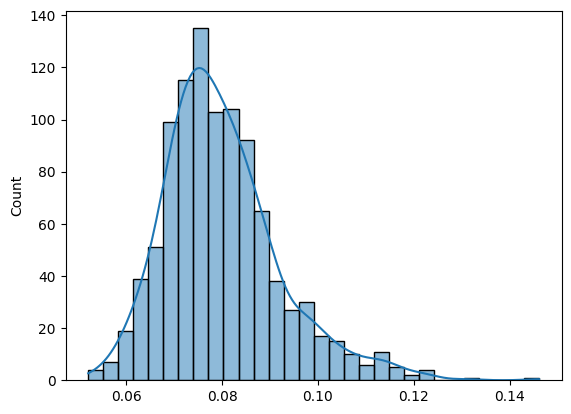

KeyboardInterrupt: 

In [21]:
for idx in range(20):

    res = create_reservoirs( n_res_samples, n_reservoir, alpha, sparsity_a, sparsity_b, sr_a, sr_b )
    
    date = datetime.today().strftime('%d-%H_%M_%S')
    file_path = 'reservoir_data/'+date+'.pickle'

    with open(file_path, 'wb') as file:
        # Serialize and write the variable to the file
        pickle.dump(res, file)
        
    print(idx+1, ':', date, end='\r')
    sns.histplot(res['mean_rmse'], bins=30, kde=True )
    plt.show()

In [22]:
np.min(res['mean_rmse'])

[0.08323800806950618,
 0.07347189855372036,
 0.06835265996324082,
 0.06956044262353257,
 0.07867131822179345,
 0.07515416839300382,
 0.07886976685494393,
 0.0751814752056624,
 0.07305217091551461,
 0.07281216135571864,
 0.07138831935420178,
 0.0798164777430338,
 0.07089756739425096,
 0.07233715045884608,
 0.08545559301027258,
 0.0935415224703061,
 0.07264827086938028,
 0.0676561236796082,
 0.07675299985141389,
 0.0804851760765195,
 0.09337954984209093,
 0.10891970510446095,
 0.08060551913518424,
 0.07703917564829899,
 0.0724031744774726,
 0.06904459585416015,
 0.08402535171899138,
 0.09080839458057163,
 0.07521507469908638,
 0.08142350876552282,
 0.07024444537891916,
 0.07278172306694329,
 0.08310065156303864,
 0.08108774832443277,
 0.08088606329166924,
 0.0947535114766123,
 0.06613553538115642,
 0.057720869867202394,
 0.07508347136634244,
 0.09799139019524188,
 0.08605672478762987,
 0.08075301820953998,
 0.08293497532387988,
 0.07945388757880999,
 0.10270292190659691,
 0.0958279710430